## Load and Prepare Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/layoffs_modeling_ready.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nTarget distribution:\n{df['Layoff_Event_Binary'].value_counts()}")
print(f"Class balance: {df['Layoff_Event_Binary'].mean():.4f}")

Dataset shape: (2736, 62)
Date range: 2020-01-01 00:00:00 to 2024-04-01 00:00:00

Target distribution:
0.0    2441
1.0     295
Name: Layoff_Event_Binary, dtype: int64
Class balance: 0.1078


## Prepare Features and Target

In [3]:
exclude_cols = ['Company', 'Date', 'year', 'quarter', 'year_quarter', 'Latest_Country', 'Layoff_Event_Binary']

feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df['Layoff_Event_Binary']

print(f"Final features: {len(feature_cols)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")

Final features: 55
X shape: (2736, 55)
y shape: (2736,)
Missing values: 0


## Temporal Train-Test Split

In [4]:
split_date = '2023-07-01' 

train_mask = df['Date'] < split_date
test_mask = df['Date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Split date: {split_date} (Q3 2023)")
print(f"\nTrain set:")
print(f"  Size: {len(X_train)}")
print(f"  Positive class: {y_train.sum()} ({y_train.mean():.4f})")
print(f"  Date range: {df[train_mask]['Date'].min().date()} to {df[train_mask]['Date'].max().date()}")
print(f"  Quarters: Q1 2020 - Q2 2023")
print(f"\nTest set:")
print(f"  Size: {len(X_test)}")
print(f"  Positive class: {y_test.sum()} ({y_test.mean():.4f})")
print(f"  Date range: {df[test_mask]['Date'].min().date()} to {df[test_mask]['Date'].max().date()}")
print(f"  Quarters: Q3 2023 - Q1 2024")

Split date: 2023-07-01 (Q3 2023)

Train set:
  Size: 2128
  Positive class: 194.0 (0.0912)
  Date range: 2020-01-01 to 2023-04-01
  Quarters: Q1 2020 - Q2 2023

Test set:
  Size: 608
  Positive class: 101.0 (0.1661)
  Date range: 2023-07-01 to 2024-04-01
  Quarters: Q3 2023 - Q1 2024


## Scale Features

In [5]:
continuous_features = [col for col in feature_cols if not col.startswith(('Industry_', 'Stage_', 'negative_', 'declining_')) and col != 'layoff_event_lag1']
binary_features = [col for col in feature_cols if col.startswith(('Industry_', 'Stage_', 'negative_', 'declining_')) or col == 'layoff_event_lag1']

print(f"Continuous features to scale: {len(continuous_features)}")
print(f"Binary features (no scaling): {len(binary_features)}")

scaler = StandardScaler()

X_train_continuous = scaler.fit_transform(X_train[continuous_features])
X_test_continuous = scaler.transform(X_test[continuous_features])

X_train_scaled = np.hstack([X_train_continuous, X_train[binary_features].values])
X_test_scaled = np.hstack([X_test_continuous, X_test[binary_features].values])

feature_names = continuous_features + binary_features

print(f"\nScaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")
print(f"Train mean: {X_train_scaled.mean():.6f}")
print(f"Train std: {X_train_scaled.std():.6f}")

Continuous features to scale: 29
Binary features (no scaling): 26

Scaled train shape: (2128, 55)
Scaled test shape: (608, 55)
Train mean: 0.075197
Train std: 0.772538


## Baseline - Decision Tree

In [39]:
from sklearn.metrics import fbeta_score, roc_auc_score, average_precision_score

dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)
y_test_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
test_acc_dt = accuracy_score(y_test, y_test_pred_dt)
test_f1_dt = f1_score(y_test, y_test_pred_dt)
test_f2_dt = fbeta_score(y_test, y_test_pred_dt, beta=2)
test_auc_dt = roc_auc_score(y_test, y_test_proba_dt)
test_auprc_dt = average_precision_score(y_test, y_test_proba_dt)

print("Decision Tree Results:")
print(f"  Train Accuracy: {train_acc_dt:.4f}")
print(f"  Test Accuracy: {test_acc_dt:.4f}")
print(f"  Test F1-Score: {test_f1_dt:.4f}")
print(f"  Test F2-Score: {test_f2_dt:.4f}")
print(f"  Test AUC-ROC: {test_auc_dt:.4f}")
print(f"  Test AUPRC: {test_auprc_dt:.4f}")

print(f"\nTest Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
print(cm_dt)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_dt, target_names=['No Layoff', 'Layoff']))

print(f"\nTop 10 Feature Importances:")
importances_dt = dt_model.feature_importances_
indices = np.argsort(importances_dt)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_dt[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_dt[idx]:.4f}")

Decision Tree Results:
  Train Accuracy: 1.0000
  Test Accuracy: 0.7484
  Test F1-Score: 0.3260
  Test F2-Score: 0.3491
  Test AUC-ROC: 0.5954
  Test AUPRC: 0.2128

Test Confusion Matrix:
[[418  89]
 [ 64  37]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.87      0.82      0.85       507
      Layoff       0.29      0.37      0.33       101

    accuracy                           0.75       608
   macro avg       0.58      0.60      0.59       608
weighted avg       0.77      0.75      0.76       608


Top 10 Feature Importances:
  Latest_Funds_Raised_Log: 0.4330
  unemployment_rate_lag1: 0.1324
  quarters_since_last_layoff: 0.0868
  avg_jobless_claims_lag1: 0.0536
  current_assets_growth_yoy: 0.0264
  current_ratio_lag1: 0.0263
  roa_lag1: 0.0241
  debt_to_assets_lag1: 0.0221
  net_income_change_qoq: 0.0215
  stockholders_equity_growth_yoy: 0.0157


## Random Forest with Class Weights

In [40]:
from sklearn.metrics import fbeta_score, roc_auc_score, average_precision_score

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
test_f1_rf = f1_score(y_test, y_test_pred_rf, zero_division=0)
test_f2_rf = fbeta_score(y_test, y_test_pred_rf, beta=2, zero_division=0)
test_auc_rf = roc_auc_score(y_test, y_test_proba_rf)
test_auprc_rf = average_precision_score(y_test, y_test_proba_rf)

print("Random Forest Results:")
print(f"  Train Accuracy: {train_acc_rf:.4f}")
print(f"  Test Accuracy: {test_acc_rf:.4f}")
print(f"  Test F1-Score: {test_f1_rf:.4f}")
print(f"  Test F2-Score: {test_f2_rf:.4f}")
print(f"  Test AUC-ROC: {test_auc_rf:.4f}")
print(f"  Test AUPRC: {test_auprc_rf:.4f}")

print(f"\nTest Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=['No Layoff', 'Layoff'], zero_division=0))

print(f"\nTop 10 Feature Importances:")
importances_rf = rf_model.feature_importances_
indices = np.argsort(importances_rf)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_rf[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_rf[idx]:.4f}")

Random Forest Results:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8339
  Test F1-Score: 0.0000
  Test F2-Score: 0.0000
  Test AUC-ROC: 0.6269
  Test AUPRC: 0.3330

Test Confusion Matrix:
[[507   0]
 [101   0]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.83      1.00      0.91       507
      Layoff       0.00      0.00      0.00       101

    accuracy                           0.83       608
   macro avg       0.42      0.50      0.45       608
weighted avg       0.70      0.83      0.76       608


Top 10 Feature Importances:
  Latest_Funds_Raised_Log: 0.1799
  avg_jobless_claims_lag1: 0.0757
  sp500_change_6mo_lag1: 0.0621
  fed_funds_rate_lag1: 0.0495
  consumer_confidence_lag1: 0.0492
  unemployment_rate_lag1: 0.0443
  gdp_growth_rate_lag1: 0.0380
  sp500_index_lag1: 0.0375
  inflation_rate_yoy_lag1: 0.0282
  current_assets_growth_yoy: 0.0280


## XGBoost 

In [41]:
from sklearn.metrics import fbeta_score, roc_auc_score, average_precision_score

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', 
                          scale_pos_weight=scale_pos_weight, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train)

y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)
y_test_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_f1_xgb = f1_score(y_test, y_test_pred_xgb)
test_f2_xgb = fbeta_score(y_test, y_test_pred_xgb, beta=2)
test_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)
test_auprc_xgb = average_precision_score(y_test, y_test_proba_xgb)

print(f"Scale pos weight: {scale_pos_weight:.2f}")
print(f"\nXGBoost Results:")
print(f"  Train Accuracy: {train_acc_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_xgb:.4f}")
print(f"  Test F1-Score: {test_f1_xgb:.4f}")
print(f"  Test F2-Score: {test_f2_xgb:.4f}")
print(f"  Test AUC-ROC: {test_auc_xgb:.4f}")
print(f"  Test AUPRC: {test_auprc_xgb:.4f}")

print(f"\nTest Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print(cm_xgb)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_xgb, target_names=['No Layoff', 'Layoff']))

print(f"\nTop 10 Feature Importances:")
importances_xgb = xgb_model.feature_importances_
indices = np.argsort(importances_xgb)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_xgb[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_xgb[idx]:.4f}")

Scale pos weight: 9.97

XGBoost Results:
  Train Accuracy: 1.0000
  Test Accuracy: 0.8586
  Test F1-Score: 0.3485
  Test F2-Score: 0.2644
  Test AUC-ROC: 0.6332
  Test AUPRC: 0.4241

Test Confusion Matrix:
[[499   8]
 [ 78  23]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.86      0.98      0.92       507
      Layoff       0.74      0.23      0.35       101

    accuracy                           0.86       608
   macro avg       0.80      0.61      0.63       608
weighted avg       0.84      0.86      0.83       608


Top 10 Feature Importances:
  unemployment_rate_lag1: 0.2450
  Latest_Funds_Raised_Log: 0.1463
  consumer_confidence_lag1: 0.1238
  quarters_since_last_layoff: 0.0390
  sp500_change_6mo_lag1: 0.0350
  Industry_Security: 0.0349
  Industry_Healthcare: 0.0349
  Industry_Infrastructure: 0.0248
  Stage_Post-IPO: 0.0230
  Industry_Marketing: 0.0213


## LightGBM

In [42]:
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, roc_auc_score, average_precision_score

lgbm_model = LGBMClassifier(random_state=42, is_unbalance=True, 
                            n_jobs=-1, verbose=-1)
lgbm_model.fit(X_train_scaled, y_train)

y_train_pred_lgbm = lgbm_model.predict(X_train_scaled)
y_test_pred_lgbm = lgbm_model.predict(X_test_scaled)
y_test_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

train_acc_lgbm = accuracy_score(y_train, y_train_pred_lgbm)
test_acc_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
test_f1_lgbm = f1_score(y_test, y_test_pred_lgbm)
test_f2_lgbm = fbeta_score(y_test, y_test_pred_lgbm, beta=2)
test_auc_lgbm = roc_auc_score(y_test, y_test_proba_lgbm)
test_auprc_lgbm = average_precision_score(y_test, y_test_proba_lgbm)

print("LightGBM Results (is_unbalance=True):")
print(f"  Train Accuracy: {train_acc_lgbm:.4f}")
print(f"  Test Accuracy: {test_acc_lgbm:.4f}")
print(f"  Test F1-Score: {test_f1_lgbm:.4f}")
print(f"  Test F2-Score: {test_f2_lgbm:.4f}")
print(f"  Test AUC-ROC: {test_auc_lgbm:.4f}")
print(f"  Test AUPRC: {test_auprc_lgbm:.4f}")

print(f"\nTest Confusion Matrix:")
cm_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)
print(cm_lgbm)

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_lgbm, target_names=['No Layoff', 'Layoff']))

print(f"\nTop 10 Feature Importances:")
importances_lgbm = lgbm_model.feature_importances_
indices = np.argsort(importances_lgbm)[::-1]
for i in range(10):
    idx = indices[i]
    if importances_lgbm[idx] > 0:
        print(f"  {feature_names[idx]}: {importances_lgbm[idx]:.4f}")

LightGBM Results (is_unbalance=True):
  Train Accuracy: 1.0000
  Test Accuracy: 0.6941
  Test F1-Score: 0.1842
  Test F2-Score: 0.1977
  Test AUC-ROC: 0.5346
  Test AUPRC: 0.1727

Test Confusion Matrix:
[[401 106]
 [ 80  21]]

Classification Report:
              precision    recall  f1-score   support

   No Layoff       0.83      0.79      0.81       507
      Layoff       0.17      0.21      0.18       101

    accuracy                           0.69       608
   macro avg       0.50      0.50      0.50       608
weighted avg       0.72      0.69      0.71       608


Top 10 Feature Importances:
  Latest_Funds_Raised_Log: 252.0000
  rd_to_assets_lag1: 188.0000
  current_liabilities_growth_yoy: 182.0000
  roe_lag1: 177.0000
  current_assets_growth_yoy: 163.0000
  debt_to_equity_lag1: 138.0000
  debt_to_assets_change_yoy: 137.0000
  stockholders_equity_growth_yoy: 132.0000
  net_income_change_qoq: 130.0000
  current_ratio_lag1: 129.0000


## Model Comparison Summary

In [43]:
results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Test_Acc': [test_acc_dt, test_acc_rf, test_acc_xgb, test_acc_lgbm],
    'Test_F1': [test_f1_dt, test_f1_rf, test_f1_xgb, test_f1_lgbm],
    'Test_F2': [test_f2_dt, test_f2_rf, test_f2_xgb, test_f2_lgbm],
    'AUC_ROC': [test_auc_dt, test_auc_rf, test_auc_xgb, test_auc_lgbm],
    'AUPRC': [test_auprc_dt, test_auprc_rf, test_auprc_xgb, test_auprc_lgbm],
    'TP': [cm_dt[1,1], cm_rf[1,1], cm_xgb[1,1], cm_lgbm[1,1]],
    'FN': [cm_dt[1,0], cm_rf[1,0], cm_xgb[1,0], cm_lgbm[1,0]],
    'FP': [cm_dt[0,1], cm_rf[0,1], cm_xgb[0,1], cm_lgbm[0,1]]
})

results_df['Recall'] = results_df['TP'] / (results_df['TP'] + results_df['FN'])
results_df['Precision'] = results_df['TP'] / (results_df['TP'] + results_df['FP'])
results_df['Precision'] = results_df['Precision'].fillna(0)

print("Model Comparison (With Class Imbalance Handling):")
print(results_df.to_string(index=False))

print(f"\nBest F1-Score: {results_df.loc[results_df['Test_F1'].idxmax(), 'Model']}")
print(f"Best F2-Score: {results_df.loc[results_df['Test_F2'].idxmax(), 'Model']}")
print(f"Best Recall: {results_df.loc[results_df['Recall'].idxmax(), 'Model']}")
print(f"Best AUC-ROC: {results_df.loc[results_df['AUC_ROC'].idxmax(), 'Model']}")
print(f"Best AUPRC: {results_df.loc[results_df['AUPRC'].idxmax(), 'Model']}")

Model Comparison (With Class Imbalance Handling):
        Model  Test_Acc  Test_F1  Test_F2  AUC_ROC    AUPRC  TP  FN  FP   Recall  Precision
Decision Tree  0.748355 0.325991 0.349057 0.595397 0.212838  37  64  89 0.366337   0.293651
Random Forest  0.833882 0.000000 0.000000 0.626887 0.333036   0 101   0 0.000000   0.000000
      XGBoost  0.858553 0.348485 0.264368 0.633234 0.424130  23  78   8 0.227723   0.741935
     LightGBM  0.694079 0.184211 0.197740 0.534644 0.172695  21  80 106 0.207921   0.165354

Best F1-Score: XGBoost
Best F2-Score: Decision Tree
Best Recall: Decision Tree
Best AUC-ROC: XGBoost
Best AUPRC: XGBoost


## ROC Curves

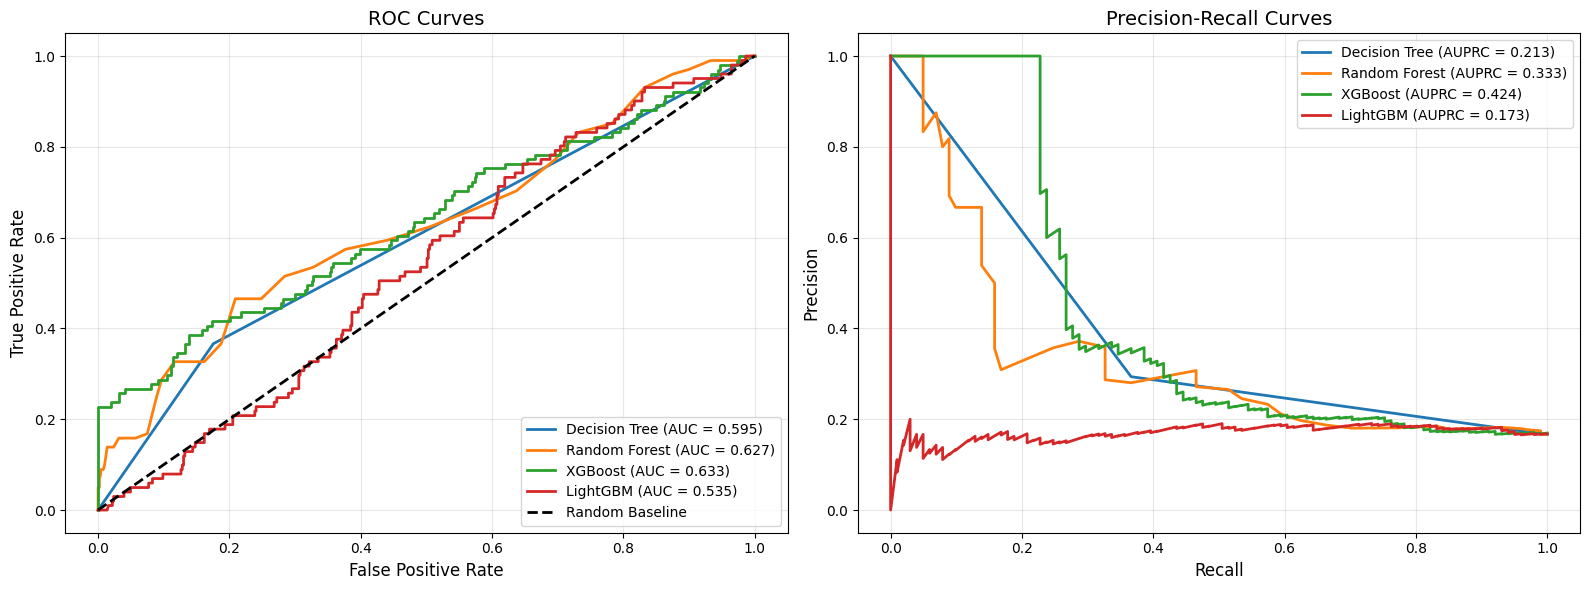


ROC AUC Scores:
  Decision Tree: 0.5954
  Random Forest: 0.6269
  XGBoost: 0.6332
  LightGBM: 0.5346

AUPRC Scores:
  Decision Tree: 0.2128
  Random Forest: 0.3330
  XGBoost: 0.4241
  LightGBM: 0.1727


In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

y_test_proba_dt = dt_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_test_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_test_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_test_proba_lgbm)

auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_test_proba_dt)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_proba_xgb)
precision_lgbm, recall_lgbm, _ = precision_recall_curve(y_test, y_test_proba_lgbm)

auprc_dt = average_precision_score(y_test, y_test_proba_dt)
auprc_rf = average_precision_score(y_test, y_test_proba_rf)
auprc_xgb = average_precision_score(y_test, y_test_proba_xgb)
auprc_lgbm = average_precision_score(y_test, y_test_proba_lgbm)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.3f})', linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)
axes[0].plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {auc_lgbm:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Baseline')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves', fontsize=14)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(alpha=0.3)

axes[1].plot(recall_dt, precision_dt, label=f'Decision Tree (AUPRC = {auprc_dt:.3f})', linewidth=2)
axes[1].plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {auprc_rf:.3f})', linewidth=2)
axes[1].plot(recall_xgb, precision_xgb, label=f'XGBoost (AUPRC = {auprc_xgb:.3f})', linewidth=2)
axes[1].plot(recall_lgbm, precision_lgbm, label=f'LightGBM (AUPRC = {auprc_lgbm:.3f})', linewidth=2)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves', fontsize=14)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/roc_pr_curves_quarterly.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nROC AUC Scores:")
print(f"  Decision Tree: {auc_dt:.4f}")
print(f"  Random Forest: {auc_rf:.4f}")
print(f"  XGBoost: {auc_xgb:.4f}")
print(f"  LightGBM: {auc_lgbm:.4f}")

print(f"\nAUPRC Scores:")
print(f"  Decision Tree: {auprc_dt:.4f}")
print(f"  Random Forest: {auprc_rf:.4f}")
print(f"  XGBoost: {auprc_xgb:.4f}")
print(f"  LightGBM: {auprc_lgbm:.4f}")

## Hyperparameter Tuning with GridSearchCV (Round 1)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score

auprc_scorer = make_scorer(average_precision_score, needs_threshold=True)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [9, 10, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'reg_lambda': [1, 5, 10]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=auprc_scorer,
    cv=3,
    n_jobs=1,
    verbose=2
)

print("Hyperparameter tuning with AUPRC optimization...")

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUPRC: {grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_

Hyperparameter tuning with AUPRC optimization...
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, scale_pos_weight=9, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, scale_pos_weight=9, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, scale_pos_weight=9, subsample=0.5; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, scale_pos_weight=9, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, scale_pos_weight=9, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_lambda=1, scale_pos_weight=9, subsample=0.6; total time=   0.0

## Hyperparameter Tuning with GridSearchCV (Round 2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score

auprc_scorer = make_scorer(average_precision_score, needs_threshold=True)

param_grid = {
    'max_depth': [3],
    'learning_rate': [0.01],
    'n_estimators': [200],
    'scale_pos_weight': [7, 8, 9],
    'min_child_weight': [5, 7, 10],
    'subsample': [0.8, 0.9, 1.0],
    'reg_lambda': [1]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=auprc_scorer,
    cv=3,
    n_jobs=1,
    verbose=2
)

print("Hyperparameter tuning with AUPRC optimization...")

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUPRC: {grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_

Hyperparameter tuning with AUPRC optimization...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_lambda=1, scale_pos_weight=7, subsample=0.8; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_lambda=1, scale_pos_weight=7, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_lambda=1, scale_pos_weight=7, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_lambda=1, scale_pos_weight=7, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_lambda=1, scale_pos_weight=7, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_lambda=1, scale_pos_weight=7, subsample=0.9; total time=   0.2s
[C

## Hyperparameter Tuning with GridSearchCV (Round 3)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score

auprc_scorer = make_scorer(average_precision_score, needs_threshold=True)

param_grid = {
    'max_depth': [3],
    'learning_rate': [0.01],
    'n_estimators': [200],
    'scale_pos_weight': [3, 5, 7],
    'min_child_weight': [10, 15, 20],
    'subsample': [0.9],
    'reg_lambda': [1]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring=auprc_scorer,
    cv=3,
    n_jobs=1,
    verbose=2
)

print("Hyperparameter tuning with AUPRC optimization...")

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV AUPRC: {grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_

Hyperparameter tuning with AUPRC optimization...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, reg_lambda=1, scale_pos_weight=3, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, reg_lambda=1, scale_pos_weight=3, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, reg_lambda=1, scale_pos_weight=3, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, reg_lambda=1, scale_pos_weight=5, subsample=0.9; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, reg_lambda=1, scale_pos_weight=5, subsample=0.9; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=200, reg_lambda=1, scale_pos_weight=5, subsample=0.9; total time=   0.

## Evaluate Tuned XGBoost with Threshold Adjustment

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score

best_xgb_final = grid_search.best_estimator_

y_test_proba_best = best_xgb_final.predict_proba(X_test_scaled)[:, 1]

test_auprc = average_precision_score(y_test, y_test_proba_best)

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba_best)

f2_scores = []
for threshold in thresholds:
    y_pred_threshold = (y_test_proba_best >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_threshold, beta=2, zero_division=0)
    f2_scores.append(f2)

best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]

y_test_pred_final = (y_test_proba_best >= best_threshold).astype(int)

test_acc_final = accuracy_score(y_test, y_test_pred_final)
test_f1_final = f1_score(y_test, y_test_pred_final)
test_f2_final = fbeta_score(y_test, y_test_pred_final, beta=2)
cm_final = confusion_matrix(y_test, y_test_pred_final)

print("Final Tuned XGBoost (AUPRC Optimized):")
print(f"  Best Parameters: {grid_search.best_params_}")
print(f"  CV AUPRC: {grid_search.best_score_:.4f}")
print(f"  Test AUPRC: {test_auprc:.4f}")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  Test Accuracy: {test_acc_final:.4f}")
print(f"  Test F1-Score: {test_f1_final:.4f}")
print(f"  Test F2-Score: {test_f2_final:.4f}")

print(f"\nConfusion Matrix:")
print(cm_final)

print(f"\nRecall: {cm_final[1,1]/101:.2%} (caught {cm_final[1,1]}/101 layoffs)")
print(f"Precision: {cm_final[1,1]/(cm_final[1,1]+cm_final[0,1]):.2%}")

Final Tuned XGBoost (AUPRC Optimized):
  Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 5, 'subsample': 0.9}
  CV AUPRC: 0.7999
  Test AUPRC: 0.4293
  Optimal Threshold: 0.284
  Test Accuracy: 0.5280
  Test F1-Score: 0.3432
  Test F2-Score: 0.5068

Confusion Matrix:
[[246 261]
 [ 26  75]]

Recall: 74.26% (caught 75/101 layoffs)
Precision: 22.32%


## Save Final Model

In [46]:
import pickle

with open('../models/best_xgb_quarterly_regularized.pkl', 'wb') as f:
    pickle.dump(best_xgb_final, f)

with open('../models/scaler_quarterly.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../models/feature_names_quarterly.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

with open('../models/optimal_threshold_quarterly.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)

print(f"Saved files to ../models/:")
print(f"  - best_xgb_quarterly_regularized.pkl")
print(f"  - scaler_quarterly.pkl")
print(f"  - feature_names_quarterly.pkl")
print(f"  - optimal_threshold_quarterly.pkl")

print(f"\nFinal Model Summary:")
print(f"  Model: XGBoost with Regularization (Quarterly Prediction)")
print(f"  Best Parameters: {grid_search.best_params_}")
print(f"  CV AUPRC: {grid_search.best_score_:.4f}")
print(f"  Test AUPRC: {test_auprc:.4f}")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  Test Accuracy: {test_acc_final:.2%}")
print(f"  Test F1-Score: {test_f1_final:.4f}")
print(f"  Test F2-Score: {test_f2_final:.4f}")
print(f"  Test Recall: {cm_final[1,1]/101:.2%} ({cm_final[1,1]}/101 layoffs caught)")
print(f"  Test Precision: {cm_final[1,1]/(cm_final[1,1]+cm_final[0,1]):.2%}")

Saved files to ../models/:
  - best_xgb_quarterly_regularized.pkl
  - scaler_quarterly.pkl
  - feature_names_quarterly.pkl
  - optimal_threshold_quarterly.pkl

Final Model Summary:
  Model: XGBoost with Regularization (Quarterly Prediction)
  Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200, 'reg_lambda': 1, 'scale_pos_weight': 5, 'subsample': 0.9}
  CV AUPRC: 0.7999
  Test AUPRC: 0.4293
  Optimal Threshold: 0.284
  Test Accuracy: 52.80%
  Test F1-Score: 0.3432
  Test F2-Score: 0.5068
  Test Recall: 74.26% (75/101 layoffs caught)
  Test Precision: 22.32%
